This file implements [this](https://github.com/AmritSd/Institutional-ownership-impact-on-stocks-near-one-dollar/issues/7) function

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

In [113]:
price_data_file = '../data/merged_price_instit_data.pkl'
three_factor_file = '../data/fama_french_factor_lagged.pkl'

price_data = pd.read_pickle(price_data_file).dropna(subset=['date'])
three_factor_data = pd.read_pickle(three_factor_file)

three_factor_data['Mkt-RF'] = three_factor_data['Mkt-RF'] / 100
three_factor_data['SMB'] = three_factor_data['SMB'] / 100
three_factor_data['HML'] = three_factor_data['HML'] / 100
three_factor_data['RF'] = three_factor_data['RF'] / 100
three_factor_data['Mkt-RF_lag1'] = three_factor_data['Mkt-RF_lag1'] / 100
three_factor_data['SMB_lag1'] = three_factor_data['SMB_lag1'] / 100
three_factor_data['HML_lag1'] = three_factor_data['HML_lag1'] / 100

In [114]:
display(price_data)
display(three_factor_data)

,PERMNO,date,EXCHCD,SICCD,TICKER,TRDSTAT,CUSIP,DLSTCD,DLRET,PRC,RET,SHROUT,cusip,fdate,shares,institutional_ownership_perc
11861,14945,2014-12-31,1.0,6799,AAC,A,00030710,NaN,NaN,30.92,-0.001292,21081000.0,00030710,2014-12-31,2954597.0,0.140154
11862,14945,2015-01-02,1.0,6799,AAC,A,00030710,NaN,NaN,30.21,-0.022963,21081000.0,00030710,2015-01-02,2954597.0,0.140154
11863,14945,2015-01-05,1.0,6799,AAC,A,00030710,NaN,NaN,29.73,-0.015889,21081000.0,00030710,2015-01-05,2954597.0,0.140154
11864,14945,2015-01-06,1.0,6799,AAC,A,00030710,NaN,NaN,29.38,-0.011773,21081000.0,00030710,2015-01-06,2954597.0,0.140154
11865,14945,2015-01-07,1.0,6799,AAC,A,00030710,NaN,NaN,28.64,-0.025187,21081000.0,00030710,2015-01-07,2954597.0,0.140154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332861,15857,2021-12-27,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.50,-0.054054,51998000.0,Y9530810,2021-12-27,30737458.0,0.591128
14332862,15857,2021-12-28,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.30,-0.057143,51998000.0,Y9530810,2021-12-28,30737458.0,0.591128
14332863,15857,2021-12-29,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.25,-0.015152,51998000.0,Y9530810,2021-12-29,30737458.0,0.591128
14332864,15857,2021-12-30,3.0,9999.0,WVE,A,Y9530810,NaN,NaN,3.28,0.009231,51998000.0,Y9530810,2021-12-30,30737458.0,0.591128


,date,Mkt-RF,SMB,HML,RF,Mkt-RF_lag1,SMB_lag1,HML_lag1
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009,0.0010,-0.0025,-0.0027
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009,0.0045,-0.0033,-0.0006
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009,0.0017,0.0030,-0.0039
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009,0.0009,-0.0058,0.0002
5,1926-07-09,-0.0071,0.0043,0.0057,0.00009,0.0021,-0.0038,0.0019
...,...,...,...,...,...,...,...,...
25394,2022-12-23,0.0051,-0.0060,0.0115,0.00016,-0.0152,0.0010,0.0037
25395,2022-12-27,-0.0051,-0.0073,0.0142,0.00016,0.0051,-0.0060,0.0115
25396,2022-12-28,-0.0123,-0.0025,-0.0029,0.00016,-0.0051,-0.0073,0.0142
25397,2022-12-29,0.0187,0.0127,-0.0107,0.00016,-0.0123,-0.0025,-0.0029


In [111]:
def regress_three_factors(price_data, three_factor_data):
    # Merge on date
    merged_data = price_data.merge(three_factor_data, on='date', how='left')
    merged_data = merged_data.dropna(subset=['RET', 'RF', 'Mkt-RF', 'SMB', 'HML', 'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1'])

    y = merged_data['RET'].astype(float) - merged_data['RF']
    # Add a constant to the X data

    X = merged_data[['Mkt-RF', 'SMB', 'HML', 'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1']].copy()
    X['constant'] = 1

    display(X)
    display(y)
    
    model = sm.OLS(y, X)

    results = model.fit()

    # return mktrf + mktrf_lag1, smb + smb_lag1, hml + hml_lag1
    
    return results.params[0] + results.params[3], results.params[1] + results.params[4], results.params[2] + results.params[5]



In [107]:
def calc_returns(stock_returns, mkt_data, smb_data, hml_data, rf_data,  beta_mktrf, beta_smb, beta_hml):
    stock_returns = np.array(stock_returns)
    mkt_data = np.array(mkt_data)
    smb_data = np.array(smb_data)
    hml_data = np.array(hml_data)

    # Calculate the alpha
    alpha = stock_returns - rf_data - beta_mktrf * mkt_data - beta_smb * smb_data - beta_hml * hml_data

    final_ret = np.prod(1 + alpha) - 1
    print(beta_mktrf, beta_smb, beta_hml)

    return final_ret

In [136]:
def detect_price_dips(single_stock_price_data, three_factor_data, threshold, visualize=False):
    """
    Detects whenever a stock price dips below a given threshold and calculates the 
    30-day, 90-day, and 180-day returns from that point on.

    Args:
        single_stock_price_data (pandas.DataFrame): Stock price data with columns 'date' and 'PRC'
        three_factor_data (pandas.DataFrame): Three factor Fama French returns with lagged factors as well.
        threshold (float): Price threshold

    Returns:
        An array containing the trades made.
        Each trade will be a dictionary
        The dictionary will contain the starting date, institutional ownership percentage, permno, cusip
        a returns dictionary containing the 30-day, 90-day, and 180-day returns, and a alphas dictionaries containing the 30-day, 90-day, and 180-day alphas
    """
    trades = []
    # Make three_factor_data decimal instead of percentage


    # State 0: Above price threshold
    # State 1: Below price threshold

    state = 1
    in_trade = False

    returns = []
    mkt_returns = []
    smb_returns = []
    hml_returns = []
    rf_returns = []

    trade = None

    beta_mktrf, beta_smb, beta_hml = (0, 0, 0)

    # Since we want atleast one year of price data for the three factor regression, we start at year 2
    start_date = single_stock_price_data.iloc[0]['date']
    start_date_plus_one_year = start_date + pd.Timedelta(days=365)

    for index, row in single_stock_price_data[single_stock_price_data['date'] >= start_date_plus_one_year].iterrows():
        price = row['PRC']
        date = row['date']
        ret = row['RET']
        trading_status = row['TRDSTAT']

        try:
            delisting_return = float(row['DLRET'])
        except:
            delisting_return = float('nan')

        if(not in_trade and state != 0 and price >= threshold):
            state = 0
        
        if(not in_trade and state == 0 and price < threshold and trading_status == 'A'):
            state = 1 # Buy
            in_trade = True
            trade = {}
            trade['start_date'] = date
            trade['institutional_ownership'] = row['institutional_ownership_perc']
            trade['permno'] = row['PERMNO']
            trade['cusip'] = row['CUSIP']
            trade['returns'] = {}
            trade['alphas'] = {}
            beta_mktrf, beta_smb, beta_hml = regress_three_factors(single_stock_price_data[single_stock_price_data['date'] < date], three_factor_data)
        
        elif(in_trade):
            returns.append(ret)
            mkt_returns.append(three_factor_data[three_factor_data['date'] == date]['Mkt-RF'].iloc[0])
            smb_returns.append(three_factor_data[three_factor_data['date'] == date]['SMB'].iloc[0])
            hml_returns.append(three_factor_data[three_factor_data['date'] == date]['HML'].iloc[0])
            rf_returns.append(three_factor_data[three_factor_data['date'] == date]['RF'].iloc[0])

                
            if(not math.isnan(delisting_return)):
                # Stock got delisted so we need to close the trade
                returns[-1] = (1 + float(returns[-1])) * (1 + delisting_return) - 1
                np_ret = np.array(returns).astype(float)
                trade['returns']['180'] = np.prod(np_ret + 1) - 1
                trade['returns']['180-end'] = date

                trade['alphas']['180'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)


                # Close the trade
                if('90' not in trade['returns']):
                    trade['returns']['90'] = trade['returns']['180']
                    trade['returns']['90-end'] = date
                    trade['alphas']['90'] = trade['alphas']['180']
                
                if('30' not in trade['returns']):
                    trade['returns']['30'] = trade['returns']['180']
                    trade['returns']['30-end'] = date
                    trade['alphas']['30'] = trade['alphas']['180']
                
                in_trade = False
                returns = []
                mkt_returns = []
                smb_returns = []
                hml_returns = []
                rf_returns = []
                trades.append(trade)
                trade = None

            elif(date >= trade['start_date'] + pd.Timedelta(days=180) and trading_status == 'A'):
                np_ret = np.array(returns).astype(float)
                trade['returns']['180'] = np.prod(np_ret + 1) - 1
                trade['returns']['180-end'] = date

                trade['alphas']['180'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)

                # Close the trade
                if('90' not in trade['returns']):
                    trade['returns']['90'] = trade['returns']['180']
                    trade['returns']['90-end'] = date
                    trade['alphas']['90'] = trade['alphas']['180']

                if('30' not in trade['returns']):
                    trade['returns']['30'] = trade['returns']['180']
                    trade['returns']['30-end'] = date
                    trade['alphas']['30'] = trade['alphas']['180']

                in_trade = False
                returns = []
                mkt_returns = []
                smb_returns = []
                hml_returns = []
                rf_returns = []
                trades.append(trade)
                trade = None
                
            elif(date >= trade['start_date'] + pd.Timedelta(days=90) and '90' not in trade['returns'] and trading_status == 'A'):
                np_ret = np.array(returns).astype(float)
                trade['returns']['90'] = np.prod(np_ret + 1) - 1
                trade['returns']['90-end'] = date

                trade['alphas']['90'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)

                if('30' not in trade['returns']):
                    trade['returns']['30'] = trade['returns']['90']
                    trade['returns']['30-end'] = date

                    trade['alphas']['30'] = trade['alphas']['90']


            elif(date >= trade['start_date'] + pd.Timedelta(days=30) and '30' not in trade['returns'] and trading_status == 'A'):
                print(date)
                np_ret = np.array(returns).astype(float)
                trade['returns']['30'] = np.prod(np_ret + 1) - 1
                trade['returns']['30-end'] = date

                trade['alphas']['30'] = calc_returns(np_ret, mkt_returns, smb_returns, hml_returns, rf_returns, beta_mktrf, beta_smb, beta_hml)



    

    if(visualize):
        visualize_trades(single_stock_price_data, trades, threshold)

    return trades


def visualize_trades(single_stock_price_data, trades, threshold):
    plt.figure(figsize=(30,10))
    plt.title('Ticker: {}'.format(single_stock_price_data['TICKER'].iloc[0]), fontsize=20)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(single_stock_price_data['date'], single_stock_price_data['PRC'])

    for trade in trades:
        # plt.axvline(x=trade['start_date'], color='g')

        # visualize returns
        if('returns' in trade):
            st = trade['start_date']

            p_1 = st + pd.Timedelta(days=30)
            if('30-end' in trade['returns']):
                p_1 = trade['returns']['30-end']
            
            p_2 = p_1 + pd.Timedelta(days=90)
            if('90-end' in trade['returns']):
                p_2 = trade['returns']['90-end']

            p_3 = p_2 + pd.Timedelta(days=90)
            if('180-end' in trade['returns']):
                p_3 = trade['returns']['180-end']


            
            if('30' in trade['returns']):
                plt.axvspan(st, p_1, color='g', alpha=0.2)
                plt.annotate('30-day ret\n{:.2f}% \nalpha\n{:.2f}'.format(trade['returns']['30'] * 100, trade['alphas']['30'] * 100), xy=(p_1,  threshold * 1.3), xytext=(p_1, threshold * 1.6), arrowprops=dict(facecolor='green', shrink=0.05))
            if('90' in trade['returns']):
                plt.axvspan(p_1, p_2, color='b', alpha=0.2)
                plt.annotate('90-day ret\n{:.2f} \nalpha\n{:.2f}%'.format(trade['returns']['90'] * 100, trade['alphas']['90'] * 100), xy=(p_2, threshold * 1.6), xytext=(p_2, threshold * 1.9), arrowprops=dict(facecolor='blue', shrink=0.05))

            if('180' in trade['returns']):
                plt.axvspan(p_2, p_3, color='r', alpha=0.2)
                plt.annotate('180-day ret\n{:.2f}% \nalpha\n{:.2f}%'.format(trade['returns']['180'] * 100, trade['alphas']['180'] * 100), xy=(p_3, threshold * 2), xytext=(p_3, threshold * 2.3), arrowprops=dict(facecolor='red', shrink=0.05))

   # Draw price threshold, thin line
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5, label='Price Threshold {:.2f}'.format(threshold), linewidth=2)

    # Highlight areas where TRDSTAT is not A
    not_a = single_stock_price_data[single_stock_price_data['TRDSTAT'] != 'A']

    # Merge consecutive rows using index
    spans = []
    span_start = None
    span_end = None
    for index, row in not_a.iterrows():
        if(span_start == None):
            span_start = index
            span_end = index
        elif(index == span_end + 1):
            span_end = index
        else:
            spans.append((span_start, span_end))
            span_start = index
            span_end = index

    if(span_start != None):
        spans.append((span_start, span_end))


    for span in spans:
        start_date = single_stock_price_data.loc[span[0]]['date']
        end_date = single_stock_price_data.loc[span[1]]['date']
        plt.axvspan(start_date, end_date, color='r', alpha=0.2)
        # Print TRDSTAT on the graph in the middle of the span
        plt.annotate('Trading status : {}'.format(single_stock_price_data.loc[span[0]]['TRDSTAT']), xy=(start_date + (end_date - start_date) / 2, threshold * 1.1), xytext=(start_date + (end_date - start_date) / 2, threshold * 1.4), arrowprops=dict(facecolor='red', shrink=0.05))



,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,-0.0093,0.0051,-0.0040,-0.0048,0.0006,0.0032,1
1,-0.0012,-0.0061,0.0008,-0.0093,0.0051,-0.0040,1
2,-0.0184,0.0033,-0.0068,-0.0012,-0.0061,0.0008,1
3,-0.0104,-0.0078,-0.0031,-0.0184,0.0033,-0.0068,1
4,0.0119,0.0020,-0.0066,-0.0104,-0.0078,-0.0031,1
...,...,...,...,...,...,...,...
460,-0.0033,-0.0096,0.0056,-0.0023,-0.0085,0.0071,1
461,-0.0029,-0.0011,0.0011,-0.0033,-0.0096,0.0056,1
462,0.0002,0.0006,0.0010,-0.0029,-0.0011,0.0011,1
463,-0.0068,-0.0037,0.0019,0.0002,0.0006,0.0010,1


0     -0.001292
1     -0.022963
2     -0.015889
3     -0.011773
4     -0.025187
         ...   
460   -0.029606
461   -0.021711
462   -0.017396
463   -0.006721
464   -0.023966
Length: 465, dtype: float64

2016-12-05 00:00:00
1.3822928218103558 1.1157377035360079 -0.11176562605745707
1.3822928218103558 1.1157377035360079 -0.11176562605745707
1.3822928218103558 1.1157377035360079 -0.11176562605745707


,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,-0.0093,0.0051,-0.0040,-0.0048,0.0006,0.0032,1
1,-0.0012,-0.0061,0.0008,-0.0093,0.0051,-0.0040,1
2,-0.0184,0.0033,-0.0068,-0.0012,-0.0061,0.0008,1
3,-0.0104,-0.0078,-0.0031,-0.0184,0.0033,-0.0068,1
4,0.0119,0.0020,-0.0066,-0.0104,-0.0078,-0.0031,1
...,...,...,...,...,...,...,...
681,-0.0012,-0.0003,-0.0006,0.0011,0.0027,0.0032,1
682,0.0019,0.0029,0.0014,-0.0012,-0.0003,-0.0006,1
683,0.0024,0.0039,0.0020,0.0019,0.0029,0.0014,1
684,0.0015,-0.0029,0.0039,0.0024,0.0039,0.0020,1


0     -0.001292
1     -0.022963
2     -0.015889
3     -0.011773
4     -0.025187
         ...   
681   -0.021509
682   -0.000050
683   -0.035138
684   -0.072777
685    0.052891
Length: 686, dtype: float64

2017-10-23 00:00:00
1.3594085641791989 1.6529411498823396 -0.18692456688904432
1.3594085641791989 1.6529411498823396 -0.18692456688904432
1.3594085641791989 1.6529411498823396 -0.18692456688904432


,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,-0.0093,0.0051,-0.0040,-0.0048,0.0006,0.0032,1
1,-0.0012,-0.0061,0.0008,-0.0093,0.0051,-0.0040,1
2,-0.0184,0.0033,-0.0068,-0.0012,-0.0061,0.0008,1
3,-0.0104,-0.0078,-0.0031,-0.0184,0.0033,-0.0068,1
4,0.0119,0.0020,-0.0066,-0.0104,-0.0078,-0.0031,1
...,...,...,...,...,...,...,...
864,-0.0014,-0.0030,0.0093,0.0086,-0.0033,0.0020,1
865,0.0031,0.0008,-0.0040,-0.0014,-0.0030,0.0093,1
866,0.0012,0.0017,-0.0017,0.0031,0.0008,-0.0040,1
867,0.0023,0.0023,-0.0063,0.0012,0.0017,-0.0017,1


0     -0.001292
1     -0.022963
2     -0.015889
3     -0.011773
4     -0.025187
         ...   
864   -0.012536
865    0.003827
866    0.000908
867   -0.001027
868   -0.020389
Length: 869, dtype: float64

2018-07-16 00:00:00
1.291879405004746 1.5253242791387362 -0.18193396662616387
1.291879405004746 1.5253242791387362 -0.18193396662616387
1.291879405004746 1.5253242791387362 -0.18193396662616387
[{'start_date': Timestamp('2016-11-03 00:00:00'), 'institutional_ownership': 0.3093258090375933, 'permno': 14945, 'cusip': '00030710', 'returns': {'30': 0.09871954622033585, '30-end': Timestamp('2016-12-05 00:00:00'), '90': 0.026924863302248525, '90-end': Timestamp('2017-02-01 00:00:00'), '180': 0.0012840514779852708, '180-end': Timestamp('2017-05-02 00:00:00')}, 'alphas': {'30': -0.06807213122449196, '90': -0.15698409141790381, '180': -0.24243680267097334}}, {'start_date': Timestamp('2017-09-21 00:00:00'), 'institutional_ownership': 0.3737883296621088, 'permno': 14945, 'cusip': '00030710', 'returns': {'30': -0.11425550760247005, '30-end': Timestamp('2017-10-23 00:00:00'), '90': -0.11006294226278768, '90-end': Timestamp('2017-12-20 00:00:00'), '180': 0.3291404148612125, '180-end': Timestamp('201

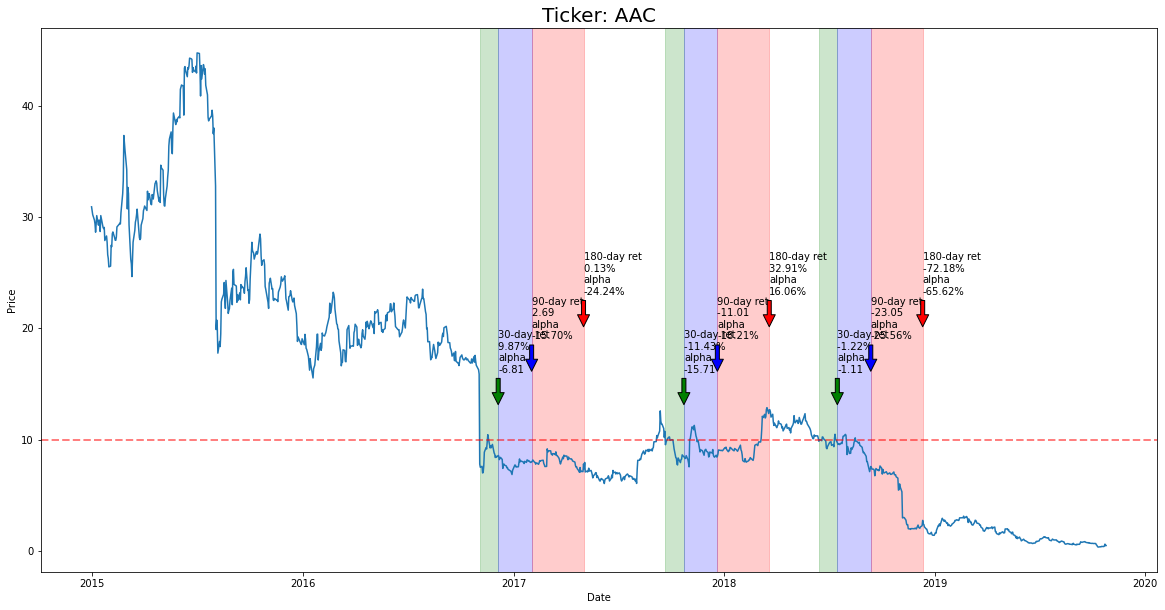

In [116]:
permno_of_interest = 14945
price_data_of_interest = price_data[price_data['PERMNO'] == permno_of_interest]
trades = detect_price_dips(price_data_of_interest, three_factor_data, 10, visualize=True)


print(trades)

In [73]:
# List of stocks where TRDSTAT is not A
trdstat_not_a = price_data[price_data['TRDSTAT'] != 'A']['PERMNO'].unique()

print(trdstat_not_a)

i = 5

[85399 77082 77327 82664 90400 15491 75941 89246 85411 77781 89986 77569
 83622 87777 83113 91428 80957 78955 84553 47423 91283 79251 55862 76310
 92206 13038 86191 15793 85570 91910 93404 93263 92802 84140 12146 85235
 88282 92102 10942 87404 79267 87310 59256 84411 79375 89169 85726 11379
 90682 79580 87514 87227 84030 84529 91522 46181 92683 88258 91893 10066
 91437 79490 88285 29744 18065 91612 62885 10051 79903 84562 78988 11636
 16086 91355 86248 90382 87464 78892 82639 16787 85377 79280 86226 77624
 85158 89796 83386 15294 48072 80640 79336 13113 14877 82191 18662 78179
 66253 88572 67002 52231 76390 77575 13878 11803 16099 80341 83532 11441
 81728 56945 57104 83657 79427 91305 88321 89175 17379 89741 16522 91434
 88459 84117 13828 90690 80915 87043 76465 76672 11275 16376 90954 90076
 14469 89312 85401 92893 85075 76577 83416 12485 81741 85953 86812 10353
 90325 87349 87810 91907 77763 73817 91366 79666 74836 14675 82670 12890
 13563 65429 12586 88270 78211 76415 76950 78003 80

,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,-0.0229,-0.0014,0.0037,0.0141,-0.0031,-0.0022,1
1,0.0124,-0.0003,0.0019,-0.0229,-0.0014,0.0037,1
2,0.0117,0.0033,-0.0031,0.0124,-0.0003,0.0019,1
3,0.0075,0.0003,0.0047,0.0117,0.0033,-0.0031,1
4,-0.0219,0.0039,-0.0006,0.0075,0.0003,0.0047,1
...,...,...,...,...,...,...,...
779,-0.0006,-0.0046,0.0134,-0.0089,-0.0075,0.0200,1
780,0.0048,-0.0083,0.0120,-0.0006,-0.0046,0.0134,1
781,0.0084,0.0043,-0.0009,0.0048,-0.0083,0.0120,1
782,-0.0136,-0.0168,0.0170,0.0084,0.0043,-0.0009,1


0     -0.022292
1      0.101975
2     -0.034923
3      0.007622
4      0.007139
         ...   
779    0.003353
780   -0.028404
781    0.019776
782   -0.118887
783   -0.006699
Length: 688, dtype: float64

2021-06-11 00:00:00
2.6650008124843176 0.2353402701505269 -0.8176678042522189
2.6650008124843176 0.2353402701505269 -0.8176678042522189
2.6650008124843176 0.2353402701505269 -0.8176678042522189


,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,-0.0229,-0.0014,0.0037,0.0141,-0.0031,-0.0022,1
1,0.0124,-0.0003,0.0019,-0.0229,-0.0014,0.0037,1
2,0.0117,0.0033,-0.0031,0.0124,-0.0003,0.0019,1
3,0.0075,0.0003,0.0047,0.0117,0.0033,-0.0031,1
4,-0.0219,0.0039,-0.0006,0.0075,0.0003,0.0047,1
...,...,...,...,...,...,...,...
912,0.0024,0.0054,0.0033,-0.0107,-0.0065,0.0093,1
913,0.0074,-0.0032,-0.0091,0.0024,0.0054,0.0033,1
914,-0.0002,-0.0054,0.0070,0.0074,-0.0032,-0.0091,1
915,0.0050,0.0004,-0.0071,-0.0002,-0.0054,0.0070,1


0     -0.022292
1      0.101975
2     -0.034923
3      0.007622
4      0.007139
         ...   
912    0.012799
913   -0.007582
914   -0.022071
915   -0.051215
916   -0.035682
Length: 821, dtype: float64

2021-12-20 00:00:00
2.8173690293276388 0.40671329149709207 -0.6866994040847775


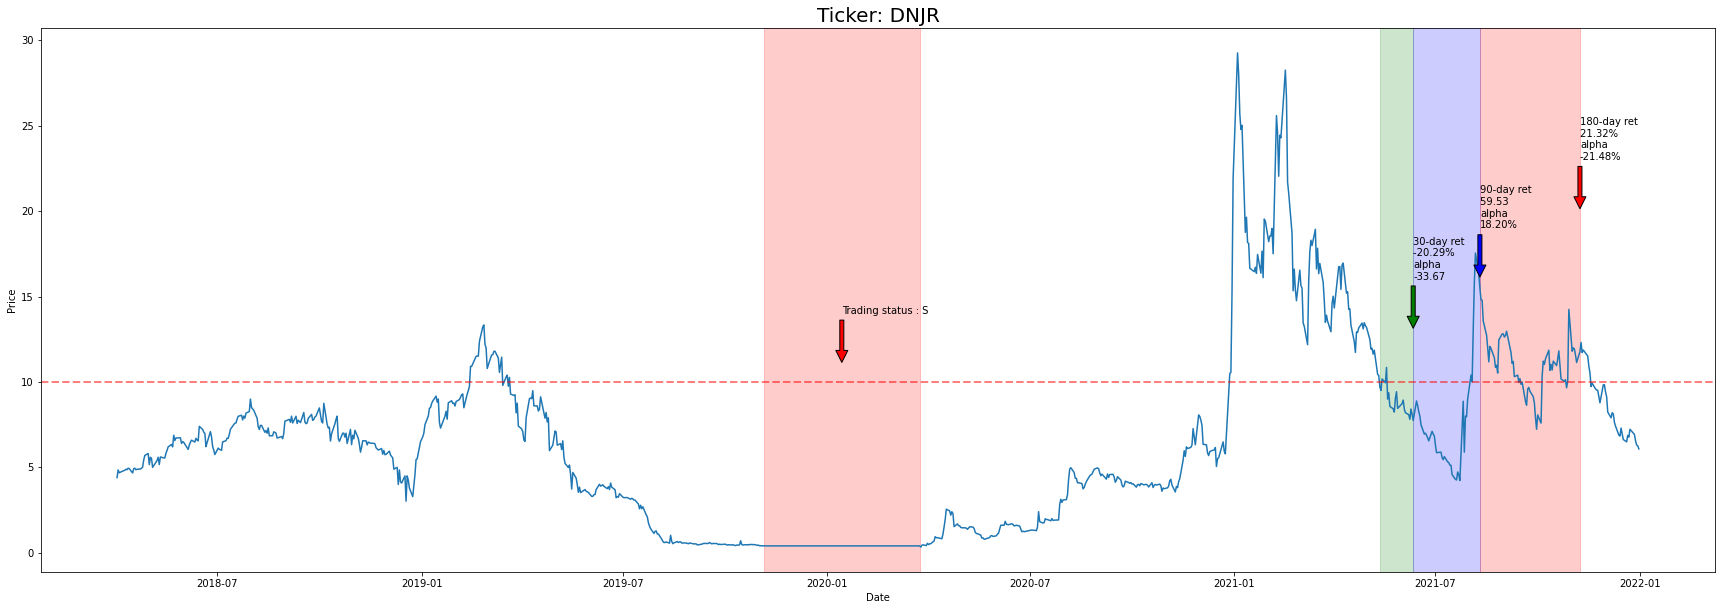

In [143]:
# Test on a stock where TRDSTAT is not A
permno_of_interest = trdstat_not_a[i]

price_data_of_interest = price_data[price_data['PERMNO'] == permno_of_interest]
trades = detect_price_dips(price_data_of_interest, three_factor_data, 10, visualize=True)

i += 1


In [81]:
# Test on a stock where delisting return is not NaN
delisting_return_not_nan = price_data[~price_data['DLRET'].isna()]['PERMNO'].unique()

i = 1

print(delisting_return_not_nan)

[14945 91561 50906 ... 86731 13633 91656]


,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,0.0099,0.0018,-0.0025,0.0077,-0.0070,0.0065,1
1,0.0145,-0.0004,0.0015,0.0099,0.0018,-0.0025,1
2,-0.0008,0.0023,-0.0085,0.0145,-0.0004,0.0015,1
3,0.0018,0.0043,-0.0058,-0.0008,0.0023,-0.0085,1
4,0.0110,0.0046,0.0016,0.0018,0.0043,-0.0058,1
...,...,...,...,...,...,...,...
839,0.0060,0.0027,-0.0052,-0.0018,-0.0006,0.0044,1
840,0.0123,0.0029,0.0020,0.0060,0.0027,-0.0052,1
841,-0.0001,-0.0026,-0.0007,0.0123,0.0029,0.0020,1
842,-0.0035,-0.0001,-0.0020,-0.0001,-0.0026,-0.0007,1


0      0.003046
1     -0.005061
2      0.001017
3      0.013211
4      0.003009
         ...   
839   -0.043860
840   -0.009174
841    0.000000
842    0.037037
843   -0.044643
Length: 844, dtype: float64

2014-12-08 00:00:00
0.8727506853417375 0.6476441586766919 0.3920074667078258
0.8727506853417375 0.6476441586766919 0.3920074667078258
0.8727506853417375 0.6476441586766919 0.3920074667078258


,Mkt-RF,SMB,HML,Mkt-RF_lag1,SMB_lag1,HML_lag1,constant
0,0.0099,0.0018,-0.0025,0.0077,-0.0070,0.0065,1
1,0.0145,-0.0004,0.0015,0.0099,0.0018,-0.0025,1
2,-0.0008,0.0023,-0.0085,0.0145,-0.0004,0.0015,1
3,0.0018,0.0043,-0.0058,-0.0008,0.0023,-0.0085,1
4,0.0110,0.0046,0.0016,0.0018,0.0043,-0.0058,1
...,...,...,...,...,...,...,...
991,0.0120,0.0016,0.0021,0.0002,-0.0031,0.0037,1
992,0.0021,-0.0011,-0.0010,0.0120,0.0016,0.0021,1
993,-0.0063,0.0033,0.0012,0.0021,-0.0011,-0.0010,1
994,-0.0045,0.0011,-0.0014,-0.0063,0.0033,0.0012,1


0      0.003046
1     -0.005061
2      0.001017
3      0.013211
4      0.003009
         ...   
991    0.019802
992    0.000000
993   -0.009709
994    0.019608
995   -0.038462
Length: 996, dtype: float64

2015-07-17 00:00:00
0.7665751827116996 1.1693753165563918 0.7899115387013671
0.7665751827116996 1.1693753165563918 0.7899115387013671
0.7665751827116996 1.1693753165563918 0.7899115387013671


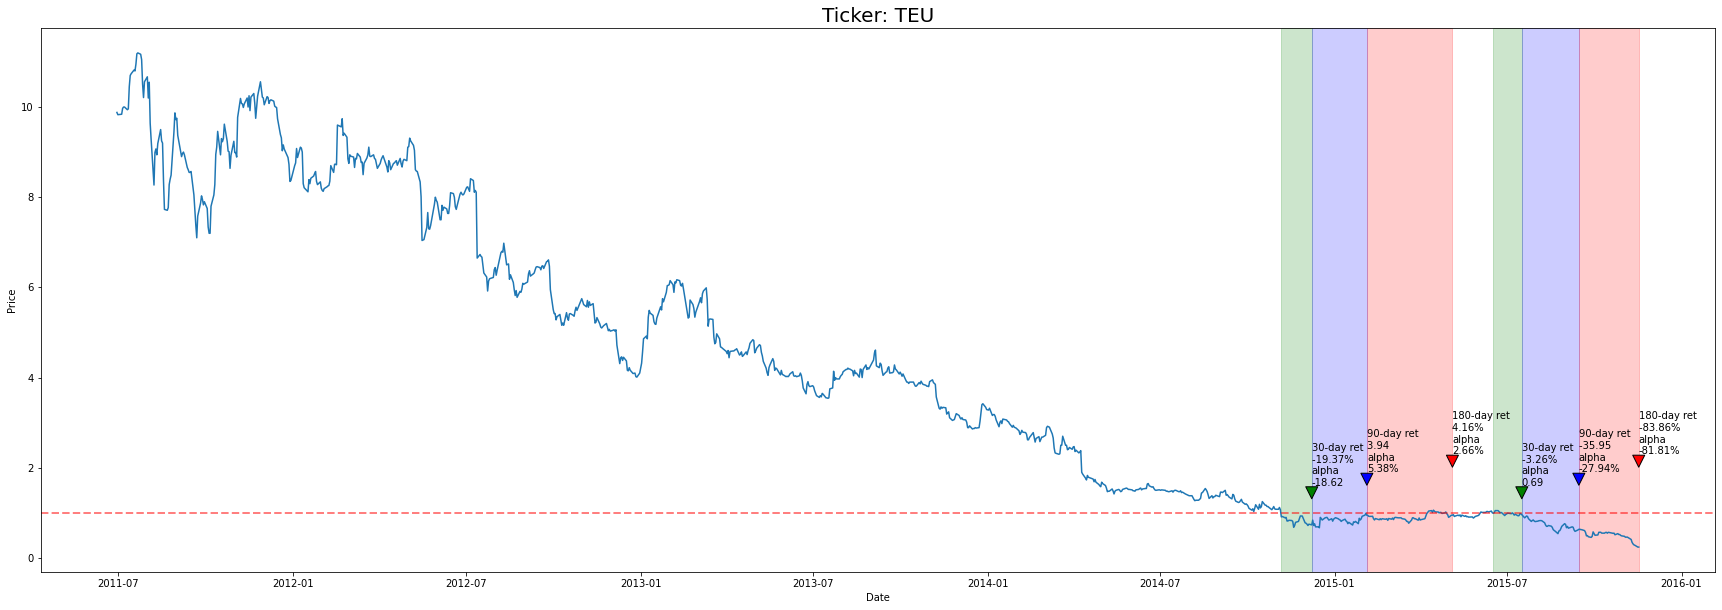

In [137]:
permno_of_interest = delisting_return_not_nan[-11]

price_data_of_interest = price_data[price_data['PERMNO'] == permno_of_interest]
trades = detect_price_dips(price_data_of_interest, three_factor_data, 1, visualize=True)




In [130]:
i

-10